<a href="https://colab.research.google.com/github/khalit7/PyTorchMnistClassification/blob/main/PyTorchMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
!pip install hiddenlayer



In [144]:
!pip install torchsummary

In [145]:
import torch
import torchvision
import torch
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import hiddenlayer as hl
from torchsummary import summary
from IPython.display import Image

import matplotlib.pyplot as plt


In [146]:

batch_size = 32


random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [147]:
train_set = torchvision.datasets.FashionMNIST (root = ".", train = True ,
download = True , transform = transforms.ToTensor ())
test_set = torchvision .datasets. FashionMNIST (root = ".", train = False ,
download = True , transform = transforms.ToTensor ())
training_loader = torch.utils.data.DataLoader (train_set , batch_size = batch_size,
shuffle = False)
test_loader = torch.utils.data.DataLoader (test_set , batch_size = batch_size,
shuffle = False)


Displaying an example of the data


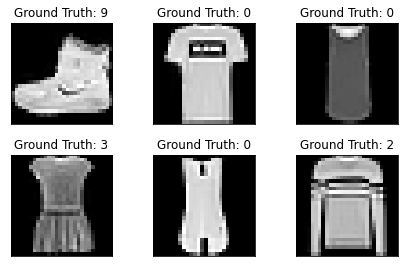

In [148]:
example = enumerate(training_loader)
batc_idx , (example_data,example_target) = next(example)
example_data.shape
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_target[i]))
  plt.xticks([])
  plt.yticks([])

lets build the network


In [149]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        # self.fc1 = nn.Linear(320, 50)
        # self.fc2 = nn.Linear(50, 10)
        self.fc1 = nn.Linear(1024,256)
        self.fc2 = nn.Linear(256,10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

# x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
# x = F.dropout(x, training=self.training)

initialize parameters

In [150]:
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 50

In [151]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

display model's archetecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
            Conv2d-2             [-1, 64, 8, 8]          51,264
            Linear-3                  [-1, 256]         262,400
            Linear-4                   [-1, 10]           2,570
Total params: 317,066
Trainable params: 317,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 1.21
Estimated Total Size (MB): 1.39
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


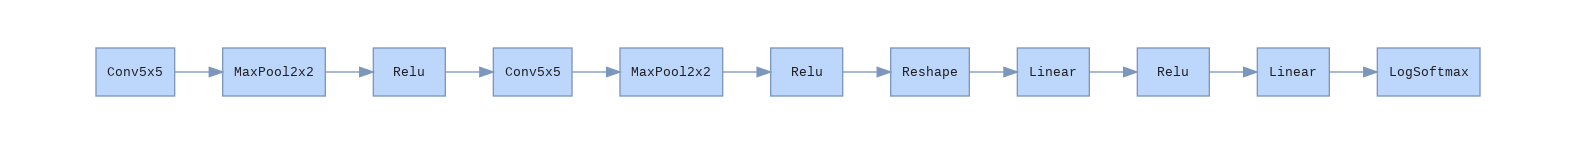

In [152]:
summary(network,(1,28,28))
transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

graph = hl.build_graph(network, example_data,transforms = transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('CNN_Model', format='png')
Image('CNN_Model.png')

Training the model

In [153]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(training_loader.dataset) for i in range(n_epochs + 1)]

In [154]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(training_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(training_loader.dataset),
        100. * batch_idx / len(training_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(training_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [155]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [156]:
optimizer.zero_grad()
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3072, Accuracy: 1034/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312130
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.225424
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.918593
Train Epoch: 1 [4800/60000 (8%)]	Loss: 1.169138
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.024137
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.165336
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.265046
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.612373
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.759673
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.826559
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.083425
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.603153
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.578953
Train Epoch: 1 [20800/60000 (35%)]	Loss: 0.958076
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.515265
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.836911
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.710538
Train Epoch: 1 [27200/60000 (45%)]	Loss: 0.987066
Train Epoch: 1 [28800/60000 (48%)]	Loss: 1.031525
Train 

Text(0, 0.5, 'negative log likelihood loss')

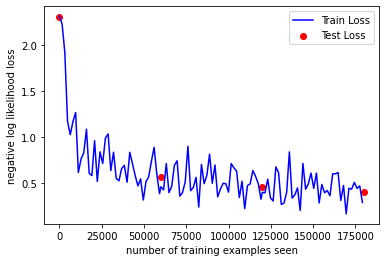

In [157]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [158]:
example = enumerate(test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


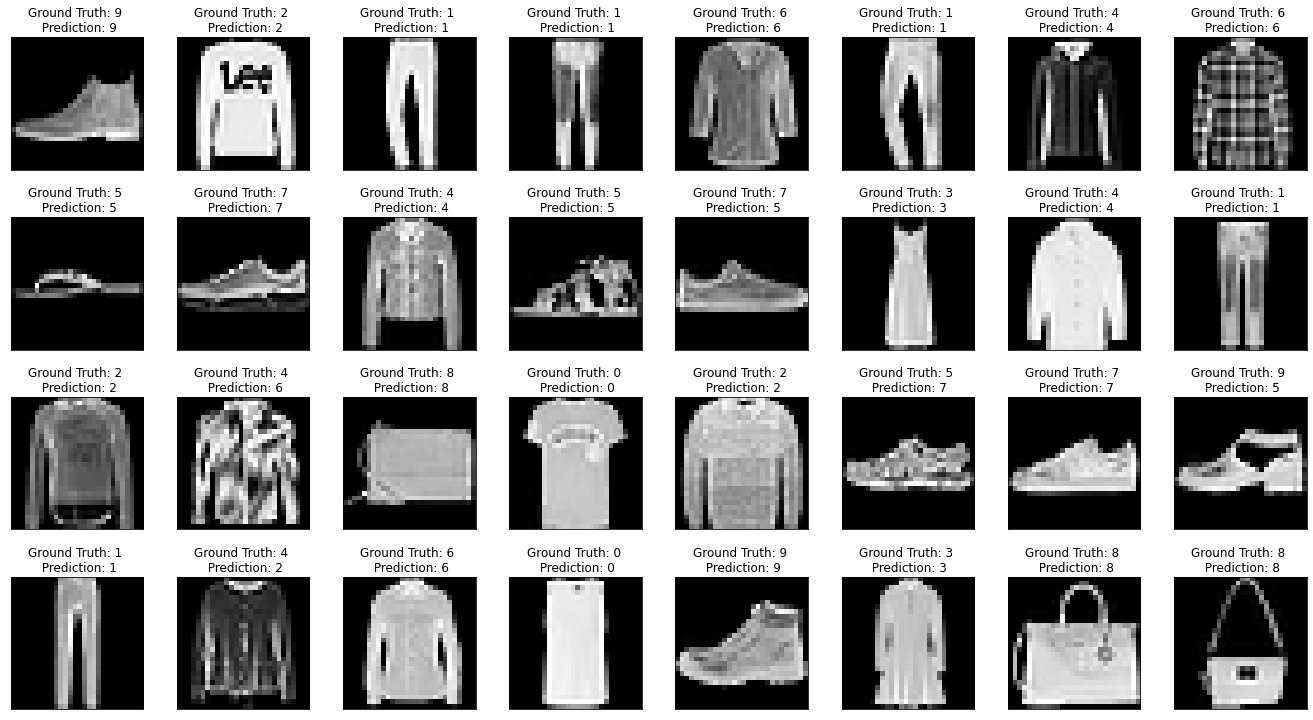

In [159]:
batc_idx , (example_data,example_target) = next(example)
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {} \n Prediction: {}".format(example_target[i],output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])